In [46]:
import numpy as np
import skimage.io as io
import skimage
from matplotlib import pyplot as plt
%matplotlib inline

In [69]:
img = io.imread('img.png')
mask = io.imread('mask.png')
print (mask.shape)

(475, 700, 3)


In [47]:
def rgb_to_yuv(img):
#     im = np.zeros((img.shape[0], img.shape[1]))
    im = 0.299* img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]
    return im

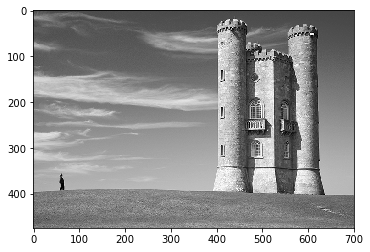

In [61]:
im = rgb_to_yuv(img)
plt.imshow(im, cmap='gray')

In [144]:
def dx(img):
#     imx = np.roll(img, 1, axis=1)
    imx = img[:,2:]
#     print(imx.shape)
    imxx = img[:,0:-2]
#     print(imxx.shape)
#     imxx = np.roll(img, -1, axis=1)
    im_x = np.zeros(img.shape)
    im_x[:,1:-1] = imx-imxx
    im_x[:,0] = img[:,1] - img[:,0]
    im_x[:,-1] = img[:,-1] - img[:,-2] 
    return im_x

In [145]:
def dy(img):
    imy = img[2:, :]
    imyy = img[0:-2,:]
    im_y = np.zeros(img.shape)
    im_y[1:-1,:] = imyy-imy
    im_y[0,:] = img[1,:] - img[0,:]
    im_y[-1,:] = img[-1,:] - img[-2,:] 
    return im_y

In [137]:
def dy(img):
    imy = np.roll(img, 1, axis=0)
    imyy = np.roll(img, -1, axis=0)
    im_y = imy-imyy
    im_y[0,:] = img[1,:] - img[0,:]
    im_y[imy.shape[0]-1,:] = img[imy.shape[0]-1,:] - img[imy.shape[0]-2,:] 
    return im_y

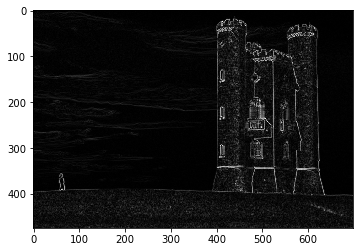

In [218]:
imx = dx(im)
imy = dy(im)
imm = np.abs(np.sqrt(imx**2+imy**2))
plt.imshow(imm, cmap='gray')
imm = (imm - imm.min())/(imm.max()-imm.min())
plt.imshow(imm, cmap='gray')
# io.imsave('imm.png', imm)
# print(np.max(im), np.min(im))

In [146]:
def my_range(start, end, step):
    while start > end:
        yield start
        start += step

In [40]:
im ,seam, mask = remove_vertical(imm,imm, np.zeros((imm.shape)))

[[ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 2.  1.  0.]
 [ 2.  2.  0.]]
[0 1 0]
[ 0.  1.  0.]


In [147]:
def remove_vertical(img, image, idxs, mask):
    seam = np.zeros(image.shape)
    seam[np.arange(0,image.shape[0]), idxs] = 1
    imag = img.reshape(image.size)
    y = np.arange(0, image.shape[0])
    idxx = y*imm.shape[1] + idxs
    imag = np.delete(imag, idxx).reshape((image.shape[0],image.shape[1]-1))
    mask = np.delete(mask, idxx).reshape((image.shape[0],image.shape[1]-1))
    # imag = imag.transpose()
    return imag, seam, mask

In [148]:
def add_vertical(im,image, idxs, mask):
    seam = np.zeros((image.shape[0],image.shape[1]+1))
    seam[np.arange(0,image.shape[0]), idxs] = 1
    imag = im.reshape(image.size)
    y = np.arange(0, image.shape[0])
    idxx = y*(image.shape[1]) + idxs
    imag = np.insert(imag, idxx+1, -1).reshape((image.shape[0],image.shape[1]+1))
    mask = np.insert(mask, idxx+1, 256*image.size).reshape((image.shape[0],image.shape[1]+1))
    idxx = np.where(imag == -1)
    for y,x in zip(idxx[0],idxx[1]):
        imag[y, x] = np.mean([imag[y, x-1 if (x-1)>0 else 0], 
                              imag[y, x+1 if (x+1)<image.shape[1] else image.shape[1]-1]])
    return imag, seam, mask

In [149]:
def seam_carve(img, string, mask = None):
    im = rgb_to_yuv(img)
    if mask is None:
        mask = np.zeros(im.shape)  
    mask = mask * (256*im.size)
    imx = dx(im)
    imy = dy(im)
    imm = np.abs(np.sqrt(imx**2+imy**2))
    imm = imm + mask
    if (string == 'vertical shrink') or (string == 'vertical expand'):
        imm = imm.transpose()
        im = im.transpose()
    image = np.zeros(imm.shape)
    image[0,:] = imm[0,:]
    for y in range(1,imm.shape[0]):
        for x in range(0,imm.shape[1]):
            up = np.array([max(x-1,0), x, min(x+1, imm.shape[1]-1)])
            m = min(image[y-1,up[0]], image[y-1,up[1]], image[y-1,up[2]])
            image[y,x] = m + imm[y,x]
    idxs = np.zeros(imm.shape[0], dtype=int)
    idxs[imm.shape[0]-1] = np.argmin(image[image.shape[0]-1,:])
    for y in my_range(imm.shape[0]-1, 0, -1):
        x=idxs[y]
        down = np.array([x-1 if (x-1)>0 else 0, x, x+1 if (x+1)<imm.shape[1]-1 else imm.shape[1]-1])
        idxs[y-1] = down[np.argmin([image[y-1,down[0]], image[y-1,down[1]], image[y-1,down[2]]])]
    if string == 'horizontal shrink': 
        im, seam, mask = remove_vertical(im,image,idxs, mask)
    elif string == 'vertical shrink':
        im,seam, mask = remove_vertical(im,image,idxs, mask)
        im = im.transpose()
        seam = seam.transpose()
    elif string == 'horizontal expand':
        im, seam, mask = add_vertical(im,image,idxs, mask)
    else:
        im, seam, mask = add_vertical(im,image,idxs, mask)
        im = im.transpose()
        seam = seam.transpose()
        mask = mask.transpose()
    return im, mask, seam

In [153]:
def seam_carve2(img, string, mask = None):
    im = rgb_to_yuv(img)
    if mask is None:
        mask = np.zeros(im.shape)  
    mask = mask * (256*im.size)
    imx = dx(im)
    imy = dy(im)
    imm = np.abs(np.sqrt(imx**2+imy**2))
    imm = imm + mask
    if (string == 'vertical shrink') or (string == 'vertical expand'):
        imm = imm.transpose()
        im = im.transpose()
    image = np.zeros(imm.shape)
    image[0,:] = imm[0,:]
    for i in range(0,imm.size-imm.shape[0]):
        x = i%imm.shape[1]
        y = i//imm.shape[0]+1
        up = np.array([max(x-1,0), x, min(x+1, imm.shape[1]-1)])
        m = min(image[y-1,up[0]], image[y-1,up[1]], image[y-1,up[2]])
        image[y,x] = m + imm[y,x]
    idxs = np.zeros(imm.shape[0], dtype=int)
    idxs[imm.shape[0]-1] = np.argmin(image[image.shape[0]-1,:])
    for y in my_range(imm.shape[0]-1, 0, -1):
        x=idxs[y]
        down = np.array([x-1 if (x-1)>0 else 0, x, x+1 if (x+1)<imm.shape[1]-1 else imm.shape[1]-1])
        idxs[y-1] = down[np.argmin([image[y-1,down[0]], image[y-1,down[1]], image[y-1,down[2]]])]
    if string == 'horizontal shrink': 
        im, seam, mask = remove_vertical(im,image,idxs, mask)
    elif string == 'vertical shrink':
        start=time()
        im,seam, mask = remove_vertical(im,image,idxs, mask)
        end = time()
        running_time = end - start
        print('time:', running_time)
        im = im.transpose()
        seam = seam.transpose()
    elif string == 'horizontal expand':
        im, seam, mask = add_vertical(im,image,idxs, mask)
    else:
        im, seam, mask = add_vertical(im,image,idxs, mask)
        im = im.transpose()
        seam = seam.transpose()
        mask = mask.transpose()
    return im, mask, seam

In [58]:
 def convert_img_to_mask(img):
        return ((img[:, :, 0] != 0) * -1 + (img[:, :, 1] != 0)).astype('int8')

In [155]:
img = io.imread('img.png')
mask = io.imread('mask.png')
maskk = convert_img_to_mask(mask)
# print (maskk.max())
# plt.imshow(mask, cmap='gray')
start = time()
im, mask, seam = seam_carve2(img, 'vertical expand', None)
end = time()
running_time = end - start
print(running_time)
start = time()
im, mask, seam = seam_carve(img, 'vertical expand', None)
end = time()
running_time = end - start
print(running_time)
# coords = np.where(seam)
# # print(coords)
# t = [i for i in zip(coords[0], coords[1])]
# t.sort(key=lambda i: i[0])
# print(tuple(t))

2.9924840927124023
2.37699031829834


In [27]:
imm = np.array([[3,4,3,5],[5,4,5,6],[1,1,1,1]])

In [54]:
from math import floor
from os import environ
from os.path import join
from pickle import load
from sys import argv


def check_test(output_dir, gt_dir):
    correct = 0
    with open(join(output_dir, 'output_seams'), 'rb') as fout, \
         open(join(gt_dir, 'seams'), 'rb') as fgt:
        for i in range(8):
            if load(fout) == load(fgt):
                correct += 1
    return 'Ok %d/8' % correct


# def grade(results_list):
#     ok_count = 0
#     for result in results_list:
#         r = result['result']
#         if r.startswith('Ok'):
#             ok_count += int(r[3:4])
#     total_count = len(results_list) * 8
#     mark = floor(ok_count / total_count / 0.1)
#     description = '%02d / %02d' % (ok_count, total_count)
#     return description, mark


def run_single_test(data_dir, output_dir):
    from numpy import where
    from os.path import join
    from pickle import dump
#     from seam_carve import seam_carve
    from skimage.io import imread

    def get_seam_coords(seam_mask):
        coords = where(seam_mask)
#         print(coords)
        t = [i for i in zip(coords[0], coords[1])]
        t.sort(key=lambda i: i[0])
        return tuple(t)

    def convert_img_to_mask(img):
        return ((img[:, :, 0] != 0) * -1 + (img[:, :, 1] != 0)).astype('int8')

    img = imread(join(data_dir, 'img.png'))
    mask = convert_img_to_mask(imread(join(data_dir, 'mask.png')))

    with open(join(output_dir, 'output_seams'), 'wb') as fhandle:
        for m in (None, mask):
            for direction in ('shrink', 'expand'):
                for orientation in ('horizontal', 'vertical'):
                    seam = seam_carve(img, orientation + ' ' + direction,
                                      mask=m)[2]
                    dump(get_seam_coords(seam), fhandle)


# if __name__ == '__main__':
#     if environ.get('CHECKER'):
#         # Script is running in testing system, run on single input
#         if len(argv) != 3:
#             print('Usage: %s data_dir output_dir' % argv[0])
#             exit(0)

#         run_single_test(argv[1], argv[2])
#     else:
#         # Script is running locally, run on dir with tests
#         if len(argv) != 2:
#             print('Usage: %s tests_dir' % argv[0])
#             exit(0)

#         from glob import glob
#         from re import sub
#         from time import time
#         from traceback import format_exc
#         from os import makedirs

#         tests_dir = argv[1]

#         results = []
#         for input_dir in sorted(glob(join(tests_dir, '[0-9][0-9]_input'))):
#             output_dir = sub('input$', 'output', input_dir)
#             makedirs(output_dir, exist_ok=True)
#             gt_dir = sub('input$', 'gt', input_dir)

#             try:
#                 start = time()
#                 run_single_test(input_dir, output_dir)
#                 end = time()
#                 running_time = end - start
#             except:
#                 result = 'Runtime error'
#                 traceback = format_exc()
#             else:
#                 try:
#                     result = check_test(output_dir, gt_dir)
#                 except:
#                     result = 'Checker error'
#                     traceback = format_exc()

#             test_num = input_dir[-8:-6]
#             if result == 'Runtime error' or result == 'Checker error':
#                 print(test_num, result, '\n', traceback)
#                 results.append({'result': result})
#             else:
#                 print(test_num, '%.2fs' % running_time, result)
#                 results.append({
#                     'time': running_time,
#                     'result': result})

#         description, mark = grade(results)
#         print('Mark:', mark, description)

In [150]:
from time import time
import os
from os.path import join
for it in range(1,8):
    input_dir = ''.join(['/Users/anoshin_alexey/Desktop/Computer Vision/public_data/0',str(it),'_input'])
    dirr = ''.join(['/Users/anoshin_alexey/Desktop/Computer Vision/public_data/0', str(it),'_output'])
    gt_dir = ''.join(['/Users/anoshin_alexey/Desktop/Computer Vision/public_data/0', str(it),'_gt'])
    # os.mkdir(dirr) 
    start = time()
    run_single_test(input_dir, dirr)
    end = time()
    running_time = end - start
    # run_single_test(input_dir, dirr)
    print(running_time)
    print(check_test(dirr, gt_dir))

17.99031686782837
Ok 8/8
16.813910007476807
Ok 8/8
16.770416975021362
Ok 8/8
7.222465991973877
Ok 8/8
5.202840805053711
Ok 8/8
14.043982028961182
Ok 8/8
10.122295141220093
Ok 8/8


In [132]:
with open(join(dirr, 'output_seams'), 'rb') as fout, \
         open(join(gt_dir, 'seams'), 'rb') as fgt:
        for i in range(8):
#             print(load(fout))
            if i==3:
                print(load(fgt))
            else:
                load(fgt)

((0, 9), (0, 10), (0, 11), (0, 13), (0, 15), (0, 17), (0, 18), (0, 19), (0, 20), (0, 22), (0, 23), (0, 26), (0, 27), (0, 29), (0, 31), (0, 32), (0, 36), (0, 37), (0, 75), (0, 80), (0, 81), (0, 82), (0, 100), (0, 101), (0, 102), (0, 103), (0, 104), (0, 105), (0, 106), (0, 107), (0, 109), (0, 111), (0, 112), (0, 113), (0, 330), (0, 331), (0, 332), (1, 7), (1, 8), (1, 12), (1, 14), (1, 16), (1, 21), (1, 24), (1, 25), (1, 28), (1, 30), (1, 33), (1, 35), (1, 38), (1, 51), (1, 62), (1, 63), (1, 73), (1, 74), (1, 76), (1, 79), (1, 83), (1, 84), (1, 85), (1, 87), (1, 88), (1, 89), (1, 92), (1, 99), (1, 108), (1, 110), (1, 114), (1, 115), (1, 329), (1, 333), (1, 335), (2, 6), (2, 34), (2, 39), (2, 40), (2, 50), (2, 52), (2, 55), (2, 58), (2, 61), (2, 64), (2, 66), (2, 68), (2, 69), (2, 70), (2, 72), (2, 77), (2, 78), (2, 86), (2, 90), (2, 91), (2, 93), (2, 94), (2, 95), (2, 96), (2, 98), (2, 116), (2, 258), (2, 261), (2, 264), (2, 266), (2, 270), (2, 328), (2, 334), (2, 336), (2, 393), (3, 0), 

In [97]:
a = np.array([1,0.5, 2.5, 3.5])
np.gradient(a)

array([-0.5 ,  0.75,  1.5 ,  1.  ])